In [8]:
"""Notebook illustrates case when linear model overtakes random forest in clf task."""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [14]:
def make_noisy_feat(mean, std, n):
  """Function to generate noisy feat.

  :param mean: mean of feat
  :param std: std of feat
  :param n: number of observations
  """
  return np.random.normal(loc=mean, scale=std, size=n)


def make_noisy_df(n_feats, n_rows):
  """Function to generate noisy df.

  :param n_feats: number of feats
  :param n_rows: number of observations
  """
  n_means = [mean for mean in range(1, n_feats * 2 + 1, 2)]
  n_std = [np.random.uniform(0, 2) for i in range(n_feats)]
  return pd.DataFrame(
      data = [feat for feat in make_noisy_feat(n_means, n_std, [n_rows, n_feats])],
      columns=[f'noisy_feat_{i}' for i in range(n_feats)]
      )


def make_correte_feat_with_target(n_corr_feats, n_rows, ratio_one_class):
  """Function to generate correlated feats with target.

  :param n_corr_feats: number of not noisy feats
  :param n_rows: number of observations
  :param ratio_one_class: ratio of class 1
  """
  n_0 = int((1 - ratio_one_class) * n_rows)
  n_1 = n_rows - n_0
  items_0 = [0] * n_0
  items_1 = [1] * n_1
  n_means_0 = [mean for mean in range(1, n_corr_feats * 2 + 1, 2)]
  n_means_1 = [mean for mean in range(n_corr_feats * 3 ** 2 , n_corr_feats * 3 ** 2 + 2, 2)]
  n_std = [np.random.uniform(0, 2) for i in range(n_corr_feats)]
  df_0 = pd.DataFrame(
      data=[feat for feat in make_noisy_feat(n_means_0, n_std, [n_0, n_corr_feats])],
      columns=[f'corr_feat_{i}' for i in range(n_corr_feats)]
      )
  
  df_0['target'] = items_0
  df_1 = pd.DataFrame(
      data=[feat for feat in make_noisy_feat(n_means_1, n_std, [n_1, n_corr_feats])],
      columns=[f'corr_feat_{i}' for i in range(n_corr_feats)]
      )
  df_1['target'] = items_1
  df = pd.concat([df_0, df_1]).reset_index(drop=True)
  return df


def make_fin_df(n_corr_feats, n_rows, ratio_1, n_noise_feats):
  """Function for concat noise df and corr df with target.

  :param n_corr_feats: number of not noisy feats
  :param n_rows: number of observations
  :param ratio_1: ratio of class 1
  :param n_noise_feats: number of noisy feats
  """
  corr_df = make_correte_feat_with_target(n_corr_feats, n_rows, ratio_1)
  noise_df = make_noisy_df(n_noise_feats, n_rows)
  all_df = pd.concat([noise_df, corr_df], axis=1)
  scaler = MinMaxScaler()
  all_df = pd.DataFrame(scaler.fit_transform(all_df), columns=all_df.columns)
  return all_df


def make_vs_experiment(df_init):
  """Make comarison of two models on test.

  :param df_init: init DataFrame
  """
  df = df_init.copy()
  X = df.drop(['target'], axis=1)
  y = df['target'].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

  clf_log_reg = LogisticRegression(random_state=0, max_iter=1500).fit(X_train, y_train)
  roc_auc_log_reg = round(clf_log_reg.score(X_test, y_test), 4)
  #print('ROC_AUC for LogReg: ', roc_auc_log_reg)

  clf_rf = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_train, y_train)
  roc_auc_rf = round(clf_rf.score(X_test, y_test), 4)
  #print('ROC_AUC for RandomForest: ', roc_auc_rf)
  return roc_auc_log_reg, roc_auc_rf

In [15]:
df = make_fin_df(1, 1000, 0.25, 500)
df.head(3)

,noisy_feat_0,noisy_feat_1,noisy_feat_2,noisy_feat_3,noisy_feat_4,noisy_feat_5,noisy_feat_6,noisy_feat_7,noisy_feat_8,noisy_feat_9,...,noisy_feat_492,noisy_feat_493,noisy_feat_494,noisy_feat_495,noisy_feat_496,noisy_feat_497,noisy_feat_498,noisy_feat_499,corr_feat_0,target
0,0.589902,0.491812,0.771452,0.480339,0.589207,0.668481,0.384323,0.466687,0.509775,0.309169,...,0.809470,0.678024,0.328997,0.531133,0.356203,0.597337,0.418207,0.473751,0.295207,0.0
1,0.560670,0.551598,0.443392,0.519189,0.466628,0.552425,0.782704,0.606491,0.608240,0.709333,...,0.406592,0.634229,0.278406,0.545299,0.371395,0.396161,0.652948,0.272300,0.308650,0.0
2,0.670726,0.514771,0.468779,0.274837,0.544335,0.439170,0.400827,0.559433,0.631246,0.516111,...,0.542676,0.628619,0.626505,0.409056,0.273012,0.781699,0.807641,0.313164,0.204582,0.0


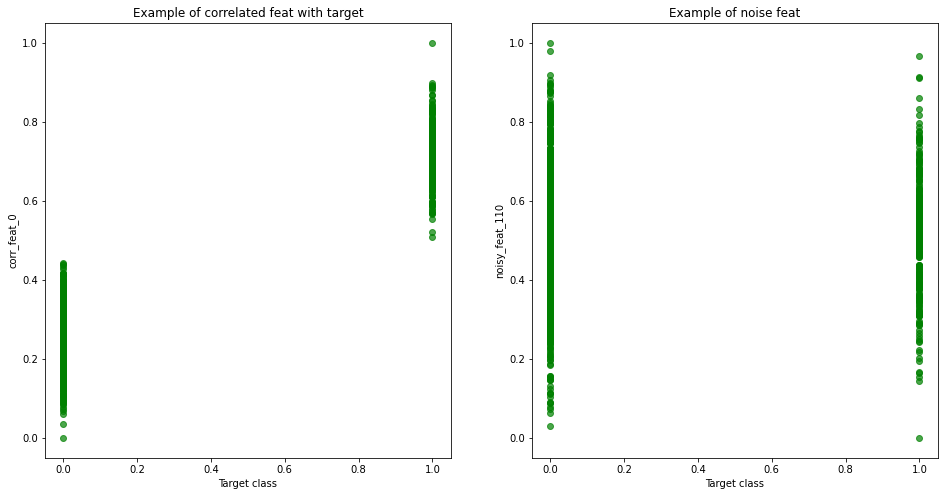

In [16]:
plt.figure(figsize=(16,8))
corr_feat = 'corr_feat_0'
plt.subplot(1, 2, 1)
plt.title('Example of correlated feat with target')
plt.scatter(df['target'].values, df[corr_feat].values, alpha=0.7, color='g')
plt.xlabel('Target class')
plt.ylabel(f'{corr_feat}')


noisy_feat = 'noisy_feat_110'
plt.subplot(1, 2, 2)
plt.title('Example of noise feat')
plt.scatter(df['target'].values, df[noisy_feat].values, alpha=0.7, color='g')
plt.ylabel(f'{noisy_feat}')
plt.xlabel('Target class')


plt.show()

In [18]:
log_reg_results = []
rf_results = []

for number_of_noise_feat in range(100, 5001, 100):
  df = make_fin_df(1, 1000, 0.25, number_of_noise_feat)
  auc_lr, auc_rf = make_vs_experiment(df)
  log_reg_results.append(auc_lr)
  rf_results.append(auc_rf)

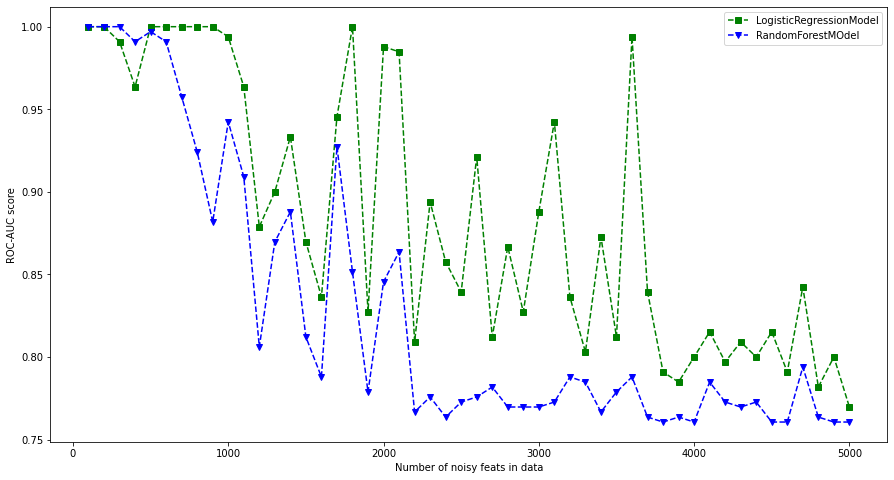

In [19]:
iters = [i for i in range(100, 5001, 100)]
plt.figure(figsize=(15,8))
plt.plot(iters, log_reg_results, 's--g', label='LogisticRegressionModel')
plt.plot(iters, rf_results, 'v--b', label='RandomForestMOdel')
plt.legend()
plt.xlabel('Number of noisy feats in data')
plt.ylabel('ROC-AUC score')
plt.show()